# Dosed Training and Evaluation

Requirements:

1. You need the data for training as h5 files, to get them you either:
  - Go through `download_and_data_format_explanation.ipynb`

    or 

  - Run `make download_example`  you can use optionnal DOWNLOAD_PATH env variable to specify an alternative directory
  
2. Have dosed installed:
    
  - Run `pip install -e .` from dosed root directory
  or 
  - Run `python setup.py develop` from dosed root directory
  


In [1]:
%matplotlib inline

In [2]:
import os
import json

h5_directory = '../data/h5'  # adapt if you used a different DOWNLOAD_PATH when running `make download_example`

# 1. Train, validation and test dataset creation

## First we select which records we want to train, validate and test on

In [3]:
import torch
import tempfile
import json
import random


from dosed.utils import Compose
from dosed.datasets import BalancedEventDataset as dataset
from dosed.models import DOSED3 as model
from dosed.datasets import get_train_validation_test
from dosed.trainers import trainers
from dosed.preprocessing import GaussianNoise, RescaleNormal, Invert

seed = 2019

In [4]:
train, validation, test = get_train_validation_test(h5_directory,
                                                    percent_test=25,
                                                    percent_validation=33,
                                                    seed=seed)

print("Number of records train:", len(train))
print("Number of records validation:", len(validation))
print("Number of records test:", len(test))

Number of records train: 11
Number of records validation: 5
Number of records test: 5


## Then we use the dataset class that will be use to generate sample for training and evaluation

- h5_directory: Location of the generic h5 files.
- signals: the signals from the h5 we want to include together with their normalization
- events: the evvents from the h5 we want to train on
- window: Spindles have a duration of ~1 seconds, so we design the samples accordingly by choosing 10 seconds windows
- ratio_positive: sample within a training batch will have a probability of "ratio_positive" to contain at least one spindle 
- n_jobs: number of process used to extract and normalize signals from h5 files.
- cache_data: cache results of extraction and normalization of signals from h5_file in h5_directory + "/.cache" (we strongly recommand to set True)



In [5]:
window = 10  # window duration in seconds
ratio_positive = 0.5  # When creating the batch, sample containing at least one spindle will be drawn with that probability

fs = 32

signals = [
    {
        'h5_path': '/eeg_0',
        'fs': 64,
        'processing': {
            "type": "clip_and_normalize",
            "args": {
                    "min_value": -150,
                "max_value": 150,
            }
        }
    },
    {
        'h5_path': '/eeg_1',
        'fs': 64,
        'processing': {
            "type": "clip_and_normalize",
            "args": {
                    "min_value": -150,
                "max_value": 150,
            }
        }
    }
]

events = [
    {
        "name": "spindle",
        "h5_path": "spindle",
    },
]

In [6]:
dataset_parameters = {
    "h5_directory": h5_directory,
    "signals": signals,
    "events": events,
    "window": window,
    "fs": fs,
    "ratio_positive": ratio_positive,
    "n_jobs": -1,  # Make use of parallel computing to extract and normalize signals from h5
    "cache_data": True,  # by default will store normalized signals extracted from h5 in h5_directory + "/.cache" directory
}

dataset_validation = dataset(records=validation, **dataset_parameters)
dataset_test = dataset(records=test, **dataset_parameters)

# for training add data augmentation
dataset_parameters_train = {
    "transformations": Compose([
        GaussianNoise(),
        RescaleNormal(),
        Invert(),
    ])
}
dataset_parameters_train.update(dataset_parameters)
dataset_train = dataset(records=train, **dataset_parameters_train)

# 2. Create a network

The main parameters for the network are:
  - default event sizes : to choose according to a priori size of the event to detect, here spindles are around 1 second
  - k_max : number of CNN layers
  

In [7]:
default_event_sizes = [0.7, 1, 1.3]
k_max = 5
kernel_size = 5
probability_dropout = 0.1
device = torch.device("cuda")

In [8]:
sampling_frequency = dataset_train.fs

net_parameters = {
    "detection_parameters": {
        "overlap_non_maximum_suppression": 0.5,
        "classification_threshold": 0.7
    },
    "default_event_sizes": [
        default_event_size * sampling_frequency
        for default_event_size in default_event_sizes
    ],
    "k_max": k_max,
    "kernel_size": kernel_size,
    "pdrop": probability_dropout,
    "fs": sampling_frequency,   # just used to print architecture info with right time
    "input_shape": dataset_train.input_shape,
    "number_of_classes": dataset_train.number_of_classes,
}
net = model(**net_parameters)
net = net.to(device)


Input feature map size: 320
Input receptive field: 0
Input size in seconds: 10.0 s
Input receptive field in seconds: 0.0 s 

After layer 1:
	Feature map size: 160
	Receptive field: 6
	Receptive field in seconds: 0.1875 s
After layer 2:
	Feature map size: 80
	Receptive field: 16
	Receptive field in seconds: 0.5 s
After layer 3:
	Feature map size: 40
	Receptive field: 36
	Receptive field in seconds: 1.125 s
After layer 4:
	Feature map size: 20
	Receptive field: 76
	Receptive field in seconds: 2.375 s
After layer 5:
	Feature map size: 10
	Receptive field: 156
	Receptive field in seconds: 4.875 s




# 3. Train the network

Parameters are
  - learning_rate
  - loss type

In [9]:
optimizer_parameters = {
    "lr": 5e-3,
    "weight_decay": 1e-8,
}
loss_specs = {
    "type": "focal",
    "parameters": {
        "number_of_classes": dataset_train.number_of_classes,
        "device": device,
    }
}
epochs = 20

In [10]:
trainer = trainers["adam"](
    net,
    optimizer_parameters=optimizer_parameters,
    loss_specs=loss_specs,
    epochs=epochs,
)

best_net_train, best_metrics_train, best_threshold_train = trainer.train(
    dataset_train,
    dataset_validation,
)

  0%|          | 0/20 [00:00<?, ?it/s]

Device:  cuda:0
Logging data to /tmp/tmpd82jp2qp/train_history.json


100%|██████████| 20/20 [51:00<00:00, 186.71s/it, best_metric_score=0.434, last_update=18, threshold=0.687]


# 4. Predict

In [11]:
predictions = best_net_train.predict_dataset(
    dataset_test,
    best_threshold_train,
)

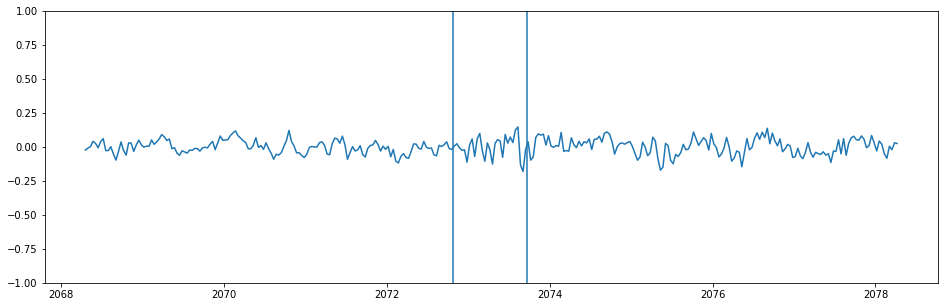

In [18]:
import matplotlib.pyplot as plt
import numpy as np

record = dataset_test.records[1]

index_spindle = 30
window_duration = 5

# retrive spindle at the right index
spindle_start = float(predictions[record][0][index_spindle][0]) / sampling_frequency
spindle_end = float(predictions[record][0][index_spindle][1]) / sampling_frequency

# center data window on annotated spindle 
start_window = spindle_start + (spindle_end - spindle_start) / 2 - window_duration
stop_window = spindle_start + (spindle_end - spindle_start) / 2 + window_duration

# Retrieve EEG data at right index
index_start = int(start_window * sampling_frequency)
index_stop = int(stop_window * sampling_frequency)
y = dataset_test.signals[record]["data"][0][index_start:index_stop]

# Build corresponding time support
t = start_window + np.cumsum(np.ones(index_stop - index_start) * 1 / sampling_frequency)

plt.figure(figsize=(16, 5))
plt.plot(t, y)
plt.axvline(spindle_end)
plt.axvline(spindle_start)
plt.ylim([-1, 1])
plt.show()